In [2]:
import sys
sys.path.append('../../')

from utils.Library import *
from utils.DataLoader import load_data

cols_to_drop = ['text', 'advanced_text', 'policy', 'antibiotics', 'self_empl', 'days_at_home', 
                'text_hist', 'text_phys_exam', 'advanced_text_hist','advanced_text_phys_exam',
                'phys_emb', 'adv_hist_emb', 'adv_phys_emb',
               ]

train_df, test_df = load_data(
    train_path='../../data/train_8000_final.p',
    test_path='../../data/test_2000_final.p',
    cols_to_drop=cols_to_drop
)

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def get_input_data(df_train, df_test, input_type, target, emb='hist_emb'):
    if input_type == "clinical_symptoms_text":
        X_train = np.array(df_train.iloc[:, :12].drop(columns=target, errors='ignore'))
        X_test = np.array(df_test.iloc[:, :12].drop(columns=target, errors='ignore'))
        X_train = np.concatenate([X_train, df_train[emb].tolist()], axis=1)
        X_test = np.concatenate([X_test, df_test[emb].tolist()], axis=1)
    elif input_type == "clinical_symptoms":
        X_train = np.array(df_train.iloc[:, :12].drop(columns=target, errors='ignore'))
        X_test = np.array(df_test.iloc[:, :12].drop(columns=target, errors='ignore'))
    elif input_type == "clinical_text":
        X_train = np.array(df_train.iloc[:, 0:5].drop(columns=target, errors='ignore'))
        X_test = np.array(df_test.iloc[:, 0:5].drop(columns=target, errors='ignore'))
        X_train = np.concatenate([X_train, df_train[emb].tolist()], axis=1)
        X_test = np.concatenate([X_test, df_test[emb].tolist()], axis=1)
    elif input_type == "clinical":
        X_train = np.array(df_train.iloc[:, :5].drop(columns=target, errors='ignore'))
        X_test = np.array(df_test.iloc[:, :5].drop(columns=target, errors='ignore'))
    elif input_type == "symptoms":
        X_train = np.array(df_train.iloc[:, 7:12].drop(columns=target, errors='ignore'))
        X_test = np.array(df_test.iloc[:, 7:12].drop(columns=target, errors='ignore'))
    elif input_type == "text":
        X_train = np.array(df_train[emb].tolist())
        X_test = np.array(df_test[emb].tolist())
    else:
        raise ValueError(f"Unknown input_type: {input_type}")
    
    return X_train, X_test


In [4]:
def NN_model_train(target, df_train, df_test, input_type='clinical_symptoms_text', emb='hist_emb'):
    # Lấy dữ liệu input theo kiểu lựa chọn
    X_train, X_test = get_input_data(df_train, df_test, input_type=input_type, target=target, emb=emb)

    y_train = df_train[target].values
    y_true = df_test[target].values  

    print("y_train shape:", y_train.shape)
    print("Input features:", X_train.shape[1])

    model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # Đã sửa sigmoid cho binary
    ])

    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = {i: class_weights[i] for i in range(len(class_weights))}

    print("Class Weights:", class_weights)

    model.fit(X_train, y_train, epochs=15, batch_size=100, validation_split=0.2, class_weight=class_weights)

    y_pred = model.predict(X_test)

    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)
    y_pred = model.predict(X_test)

    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)

    return model, roc_auc, fpr, tpr, recall, precision



In [5]:
input_types = ['symptoms', 'clinical', 'clinical_symptoms', 'clinical_text', 'clinical_symptoms_text']
all_results = {}

for input_type in input_types:
    print(f"\n Running input_type: {input_type}")
    best_pr_auc = -1
    best_result = None

    for seed in [21, 2, 13, 3, 2023]:
        print(f"  ➤ Seed {seed}")
        np.random.seed(seed)
        tf.random.set_seed(seed)

        model, roc_auc, fpr, tpr, recall, precision = NN_model_train(
            target='pneu',
            df_train=train_df,
            df_test=test_df,
            input_type=input_type,
            emb='hist_emb'
        )

        pr_auc = auc(recall, precision)

        if pr_auc > best_pr_auc:
            best_pr_auc = pr_auc
            best_result = {
                'seed': seed,
                'roc_auc': roc_auc,
                'pr_auc': pr_auc,
                'fpr': fpr,
                'tpr': tpr,
                'recall': recall,
                'precision': precision
            }

    all_results[input_type] = best_result




 Running input_type: symptoms
  ➤ Seed 21
y_train shape: (8000,)
Input features: 5


C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9178 - loss: 0.6097 - val_accuracy: 0.8225 - val_loss: 0.3562
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8755 - loss: 0.2908 - val_accuracy: 0.9112 - val_loss: 0.2666
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9176 - loss: 0.2492 - val_accuracy: 0.9287 - val_loss: 0.2599
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9184 - loss: 0.2442 - val_accuracy: 0.9287 - val_loss: 0.2616
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9183 - loss: 0.2414 - val_accuracy: 0.9287 - val_loss: 0.2611
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9184 - loss: 0.2385 - val_accuracy: 0.9287 - val_loss: 0.2577
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9180 - loss: 0.2367 - val_accuracy: 0.9262 - val_loss: 0.2592
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7381 - loss: 0.5805 - val_accuracy: 0.9219 - val_loss: 0.2776
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8988 - loss: 0.2867 - val_accuracy: 0.9394 - val_loss: 0.1490
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9226 - loss: 0.2465 - val_accuracy: 0.9375 - val_loss: 0.1575
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9207 - loss: 0.2426 - val_accuracy: 0.9350 - val_loss: 0.1755
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9183 - loss: 0.2430 - val_accuracy: 0.9294 - val_loss: 0.2002
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9125 - loss: 0.2434 - val_accuracy: 0.9294 - val_loss: 0.2128
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9116 - loss: 0.2408 - val_accuracy: 0.9294 - val_loss: 0.2159
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8953 - loss: 0.6037 - val_accuracy: 0.8225 - val_loss: 0.4252
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8394 - loss: 0.2944 - val_accuracy: 0.9112 - val_loss: 0.2783
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9037 - loss: 0.2347 - val_accuracy: 0.9287 - val_loss: 0.2534
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9131 - loss: 0.2233 - val_accuracy: 0.9287 - val_loss: 0.2420
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9146 - loss: 0.2187 - val_accuracy: 0.9287 - val_loss: 0.2377
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9136 - loss: 0.2157 - val_accuracy: 0.9287 - val_loss: 0.2322
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9132 - loss: 0.2142 - val_accuracy: 0.9300 - val_loss: 0.2284
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6686 - loss: 0.5754 - val_accuracy: 0.8231 - val_loss: 0.3949
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8585 - loss: 0.2753 - val_accuracy: 0.9112 - val_loss: 0.3346
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9116 - loss: 0.2416 - val_accuracy: 0.9087 - val_loss: 0.3242
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9089 - loss: 0.2359 - val_accuracy: 0.9000 - val_loss: 0.3124
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9094 - loss: 0.2333 - val_accuracy: 0.9175 - val_loss: 0.3056
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9089 - loss: 0.2319 - val_accuracy: 0.9175 - val_loss: 0.2977
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9087 - loss: 0.2305 - val_accuracy: 0.9175 - val_loss: 0.2847
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8314 - loss: 0.5708 - val_accuracy: 0.8450 - val_loss: 0.2907
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8633 - loss: 0.2978 - val_accuracy: 0.9331 - val_loss: 0.1993
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9129 - loss: 0.2487 - val_accuracy: 0.9350 - val_loss: 0.1763
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9148 - loss: 0.2404 - val_accuracy: 0.9350 - val_loss: 0.1727
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9155 - loss: 0.2363 - val_accuracy: 0.9350 - val_loss: 0.1708
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9159 - loss: 0.2343 - val_accuracy: 0.9350 - val_loss: 0.1719
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9170 - loss: 0.2319 - val_accuracy: 0.9350 - val_loss: 0.1747
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8543 - loss: 0.6551 - val_accuracy: 0.4538 - val_loss: 0.7553
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5085 - loss: 0.6347 - val_accuracy: 0.5169 - val_loss: 0.7057
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5153 - loss: 0.6256 - val_accuracy: 0.5169 - val_loss: 0.6876
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5469 - loss: 0.6214 - val_accuracy: 0.5169 - val_loss: 0.6898
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5604 - loss: 0.6202 - val_accuracy: 0.5169 - val_loss: 0.6818
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6043 - loss: 0.6183 - val_accuracy: 0.5169 - val_loss: 0.6779
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6228 - loss: 0.6178 - val_accuracy: 0.6019 - val_loss: 0.6785
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4645 - loss: 0.7054 - val_accuracy: 0.5194 - val_loss: 0.7037
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5212 - loss: 0.6836 - val_accuracy: 0.6044 - val_loss: 0.6287
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6817 - loss: 0.6820 - val_accuracy: 0.6044 - val_loss: 0.6241
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7344 - loss: 0.6791 - val_accuracy: 0.6019 - val_loss: 0.6293
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6804 - loss: 0.6789 - val_accuracy: 0.6019 - val_loss: 0.6240
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7144 - loss: 0.6784 - val_accuracy: 0.6019 - val_loss: 0.6289
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6839 - loss: 0.6777 - val_accuracy: 0.6019 - val_loss: 0.6262
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8813 - loss: 0.6449 - val_accuracy: 0.5144 - val_loss: 0.6852
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5384 - loss: 0.6142 - val_accuracy: 0.5144 - val_loss: 0.6658
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5099 - loss: 0.6042 - val_accuracy: 0.5144 - val_loss: 0.6584
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5215 - loss: 0.6004 - val_accuracy: 0.5169 - val_loss: 0.6603
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5191 - loss: 0.5990 - val_accuracy: 0.6019 - val_loss: 0.6542
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5354 - loss: 0.5976 - val_accuracy: 0.6019 - val_loss: 0.6521
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5833 - loss: 0.5956 - val_accuracy: 0.6019 - val_loss: 0.6495
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3640 - loss: 0.7203 - val_accuracy: 0.4569 - val_loss: 0.7271
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4587 - loss: 0.6934 - val_accuracy: 0.6044 - val_loss: 0.6633
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5193 - loss: 0.6874 - val_accuracy: 0.6019 - val_loss: 0.6420
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5403 - loss: 0.6761 - val_accuracy: 0.6019 - val_loss: 0.6322
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5441 - loss: 0.6742 - val_accuracy: 0.6019 - val_loss: 0.6268
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5671 - loss: 0.6718 - val_accuracy: 0.6019 - val_loss: 0.6277
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5723 - loss: 0.6707 - val_accuracy: 0.6019 - val_loss: 0.6252
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8167 - loss: 0.7071 - val_accuracy: 0.5194 - val_loss: 0.6980
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5217 - loss: 0.6670 - val_accuracy: 0.5169 - val_loss: 0.6610
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5410 - loss: 0.6542 - val_accuracy: 0.5169 - val_loss: 0.6480
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5427 - loss: 0.6491 - val_accuracy: 0.5169 - val_loss: 0.6425
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5564 - loss: 0.6462 - val_accuracy: 0.7950 - val_loss: 0.6294
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7277 - loss: 0.6459 - val_accuracy: 0.6012 - val_loss: 0.6319
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7184 - loss: 0.6435 - val_accuracy: 0.6012 - val_loss: 0.6346
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,585 (76.50 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8807 - loss: 0.5831 - val_accuracy: 0.8481 - val_loss: 0.3479
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8626 - loss: 0.2857 - val_accuracy: 0.9287 - val_loss: 0.2372
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9246 - loss: 0.2327 - val_accuracy: 0.9319 - val_loss: 0.2186
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9299 - loss: 0.2142 - val_accuracy: 0.9244 - val_loss: 0.2195
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9328 - loss: 0.2007 - val_accuracy: 0.9294 - val_loss: 0.2218
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9343 - loss: 0.1913 - val_accuracy: 0.9300 - val_loss: 0.2237
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9354 - loss: 0.1840 - val_accuracy: 0.9331 - val_loss: 0.2225
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_33 (Dense)                │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,585 (76.50 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5934 - loss: 0.5251 - val_accuracy: 0.9306 - val_loss: 0.2768
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9077 - loss: 0.2915 - val_accuracy: 0.9669 - val_loss: 0.1269
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9283 - loss: 0.2368 - val_accuracy: 0.9706 - val_loss: 0.0967
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9444 - loss: 0.2163 - val_accuracy: 0.9725 - val_loss: 0.0897
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9453 - loss: 0.2027 - val_accuracy: 0.9712 - val_loss: 0.0895
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9473 - loss: 0.1902 - val_accuracy: 0.9694 - val_loss: 0.0894
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9480 - loss: 0.1792 - val_accuracy: 0.9688 - val_loss: 0.0926
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,585 (76.50 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8628 - loss: 0.6094 - val_accuracy: 0.8119 - val_loss: 0.4071
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8252 - loss: 0.3047 - val_accuracy: 0.9125 - val_loss: 0.2623
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8978 - loss: 0.2264 - val_accuracy: 0.9256 - val_loss: 0.2236
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9080 - loss: 0.2024 - val_accuracy: 0.9287 - val_loss: 0.2080
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9161 - loss: 0.1895 - val_accuracy: 0.9369 - val_loss: 0.1983
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9191 - loss: 0.1798 - val_accuracy: 0.9406 - val_loss: 0.1900
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9237 - loss: 0.1728 - val_accuracy: 0.9413 - val_loss: 0.1850
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_39 (Dense)                │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,585 (76.50 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7831 - loss: 0.5815 - val_accuracy: 0.8094 - val_loss: 0.4285
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8422 - loss: 0.2831 - val_accuracy: 0.9038 - val_loss: 0.3401
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9050 - loss: 0.2288 - val_accuracy: 0.9038 - val_loss: 0.3171
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9074 - loss: 0.2155 - val_accuracy: 0.9087 - val_loss: 0.3053
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9086 - loss: 0.2082 - val_accuracy: 0.9062 - val_loss: 0.2986
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9100 - loss: 0.2025 - val_accuracy: 0.9069 - val_loss: 0.2902
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9077 - loss: 0.1979 - val_accuracy: 0.8888 - val_loss: 0.2824
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_42 (Dense)                │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,585 (76.50 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7744 - loss: 0.5691 - val_accuracy: 0.8850 - val_loss: 0.2593
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8844 - loss: 0.2903 - val_accuracy: 0.9525 - val_loss: 0.1686
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9263 - loss: 0.2244 - val_accuracy: 0.9606 - val_loss: 0.1476
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9326 - loss: 0.2047 - val_accuracy: 0.9594 - val_loss: 0.1386
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9367 - loss: 0.1947 - val_accuracy: 0.9594 - val_loss: 0.1371
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9399 - loss: 0.1872 - val_accuracy: 0.9600 - val_loss: 0.1365
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9391 - loss: 0.1812 - val_accuracy: 0.9538 - val_loss: 0.1361
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 256)            │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 214,657 (838.50 KB)

 Trainable params: 214,657 (838.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9523 - loss: 0.6146 - val_accuracy: 0.7412 - val_loss: 0.4285
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8247 - loss: 0.4378 - val_accuracy: 0.7887 - val_loss: 0.4060
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8449 - loss: 0.3417 - val_accuracy: 0.7956 - val_loss: 0.4049
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8668 - loss: 0.2826 - val_accuracy: 0.8213 - val_loss: 0.3717
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8898 - loss: 0.2378 - val_accuracy: 0.8494 - val_loss: 0.3269
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9102 - loss: 0.1957 - val_accuracy: 0.8788 - val_loss: 0.2769
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9293 - loss: 0.1551 - val_accuracy: 0.9006 - val_loss: 0.2499
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 256)            │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 214,657 (838.50 KB)

 Trainable params: 214,657 (838.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7477 - loss: 0.6365 - val_accuracy: 0.9156 - val_loss: 0.2544
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8073 - loss: 0.3953 - val_accuracy: 0.9094 - val_loss: 0.2434
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8573 - loss: 0.3225 - val_accuracy: 0.9150 - val_loss: 0.2237
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8871 - loss: 0.2701 - val_accuracy: 0.9306 - val_loss: 0.1874
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9068 - loss: 0.2205 - val_accuracy: 0.9406 - val_loss: 0.1525
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9297 - loss: 0.1762 - val_accuracy: 0.9494 - val_loss: 0.1354
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9415 - loss: 0.1403 - val_accuracy: 0.9513 - val_loss: 0.1247
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_51 (Dense)                │ (None, 256)            │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 214,657 (838.50 KB)

 Trainable params: 214,657 (838.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9548 - loss: 0.6288 - val_accuracy: 0.6231 - val_loss: 0.5376
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6899 - loss: 0.4638 - val_accuracy: 0.6325 - val_loss: 0.6216
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7638 - loss: 0.3607 - val_accuracy: 0.7369 - val_loss: 0.5169
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8207 - loss: 0.2969 - val_accuracy: 0.7919 - val_loss: 0.4298
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8572 - loss: 0.2488 - val_accuracy: 0.8275 - val_loss: 0.3687
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8817 - loss: 0.2100 - val_accuracy: 0.8619 - val_loss: 0.3095
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9072 - loss: 0.1763 - val_accuracy: 0.9081 - val_loss: 0.2329
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_54 (Dense)                │ (None, 256)            │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 214,657 (838.50 KB)

 Trainable params: 214,657 (838.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6785 - loss: 0.6529 - val_accuracy: 0.6244 - val_loss: 0.6529
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7919 - loss: 0.3995 - val_accuracy: 0.6644 - val_loss: 0.6533
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8332 - loss: 0.3228 - val_accuracy: 0.7038 - val_loss: 0.6198
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8578 - loss: 0.2743 - val_accuracy: 0.7350 - val_loss: 0.5724
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8791 - loss: 0.2335 - val_accuracy: 0.7894 - val_loss: 0.4877
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8991 - loss: 0.1900 - val_accuracy: 0.8413 - val_loss: 0.3907
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9234 - loss: 0.1501 - val_accuracy: 0.8669 - val_loss: 0.3221
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_57 (Dense)                │ (None, 256)            │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 214,657 (838.50 KB)

 Trainable params: 214,657 (838.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8321 - loss: 0.6515 - val_accuracy: 0.8344 - val_loss: 0.3427
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7922 - loss: 0.4857 - val_accuracy: 0.8819 - val_loss: 0.2704
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8416 - loss: 0.3831 - val_accuracy: 0.9000 - val_loss: 0.2384
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8617 - loss: 0.3244 - val_accuracy: 0.9169 - val_loss: 0.2093
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8853 - loss: 0.2594 - val_accuracy: 0.9256 - val_loss: 0.1871
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9055 - loss: 0.2093 - val_accuracy: 0.9431 - val_loss: 0.1516
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9239 - loss: 0.1632 - val_accuracy: 0.9563 - val_loss: 0.1211
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                │ (None, 256)            │       199,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,193 (844.50 KB)

 Trainable params: 216,193 (844.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9009 - loss: 0.4990 - val_accuracy: 0.8913 - val_loss: 0.3101
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9141 - loss: 0.2593 - val_accuracy: 0.8981 - val_loss: 0.2831
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9174 - loss: 0.2090 - val_accuracy: 0.9019 - val_loss: 0.2675
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9202 - loss: 0.1816 - val_accuracy: 0.9212 - val_loss: 0.2184
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9287 - loss: 0.1541 - val_accuracy: 0.9381 - val_loss: 0.1738
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9440 - loss: 0.1295 - val_accuracy: 0.9463 - val_loss: 0.1481
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9516 - loss: 0.1066 - val_accuracy: 0.9525 - val_loss: 0.1378
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_63 (Dense)                │ (None, 256)            │       199,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,193 (844.50 KB)

 Trainable params: 216,193 (844.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8654 - loss: 0.5091 - val_accuracy: 0.9444 - val_loss: 0.1539
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9050 - loss: 0.2539 - val_accuracy: 0.9594 - val_loss: 0.1151
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9253 - loss: 0.2110 - val_accuracy: 0.9663 - val_loss: 0.0952
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9368 - loss: 0.1791 - val_accuracy: 0.9719 - val_loss: 0.0828
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9460 - loss: 0.1479 - val_accuracy: 0.9769 - val_loss: 0.0696
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9523 - loss: 0.1188 - val_accuracy: 0.9787 - val_loss: 0.0604
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9606 - loss: 0.0936 - val_accuracy: 0.9800 - val_loss: 0.0560
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_66 (Dense)                │ (None, 256)            │       199,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,193 (844.50 KB)

 Trainable params: 216,193 (844.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9687 - loss: 0.5848 - val_accuracy: 0.8363 - val_loss: 0.3801
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8743 - loss: 0.2756 - val_accuracy: 0.8888 - val_loss: 0.3052
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8976 - loss: 0.2047 - val_accuracy: 0.9100 - val_loss: 0.2342
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9081 - loss: 0.1686 - val_accuracy: 0.9312 - val_loss: 0.1822
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9217 - loss: 0.1433 - val_accuracy: 0.9419 - val_loss: 0.1651
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9357 - loss: 0.1258 - val_accuracy: 0.9525 - val_loss: 0.1394
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9471 - loss: 0.1074 - val_accuracy: 0.9569 - val_loss: 0.1188
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_69 (Dense)                │ (None, 256)            │       199,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,193 (844.50 KB)

 Trainable params: 216,193 (844.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7126 - loss: 0.5078 - val_accuracy: 0.7644 - val_loss: 0.5449
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8878 - loss: 0.2345 - val_accuracy: 0.8081 - val_loss: 0.4551
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9057 - loss: 0.1979 - val_accuracy: 0.8331 - val_loss: 0.4182
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9146 - loss: 0.1738 - val_accuracy: 0.8612 - val_loss: 0.3743
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9256 - loss: 0.1542 - val_accuracy: 0.8894 - val_loss: 0.3293
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9345 - loss: 0.1323 - val_accuracy: 0.9069 - val_loss: 0.2736
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9439 - loss: 0.1122 - val_accuracy: 0.9269 - val_loss: 0.2242
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_72 (Dense)                │ (None, 256)            │       199,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,193 (844.50 KB)

 Trainable params: 216,193 (844.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8750 - loss: 0.5366 - val_accuracy: 0.9425 - val_loss: 0.1595
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9101 - loss: 0.2569 - val_accuracy: 0.9544 - val_loss: 0.1172
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9311 - loss: 0.1882 - val_accuracy: 0.9575 - val_loss: 0.1095
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9419 - loss: 0.1554 - val_accuracy: 0.9619 - val_loss: 0.1056
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9471 - loss: 0.1306 - val_accuracy: 0.9663 - val_loss: 0.0951
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9548 - loss: 0.1102 - val_accuracy: 0.9719 - val_loss: 0.0823
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9581 - loss: 0.0949 - val_accuracy: 0.9750 - val_loss: 0.0686
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accur


🎯 Best results by input_type (based on PR AUC):


  - symptoms       : Seed = 2, ROC AUC = 0.9689, PR AUC = 0.2985
  - clinical       : Seed = 2, ROC AUC = 0.6158, PR AUC = 0.0110
  - clinical_symptoms: Seed = 2023, ROC AUC = 0.9348, PR AUC = 0.3954
  - clinical_text  : Seed = 2023, ROC AUC = 0.9772, PR AUC = 0.3933
  - clinical_symptoms_text: Seed = 3, ROC AUC = 0.9809, PR AUC = 0.6790


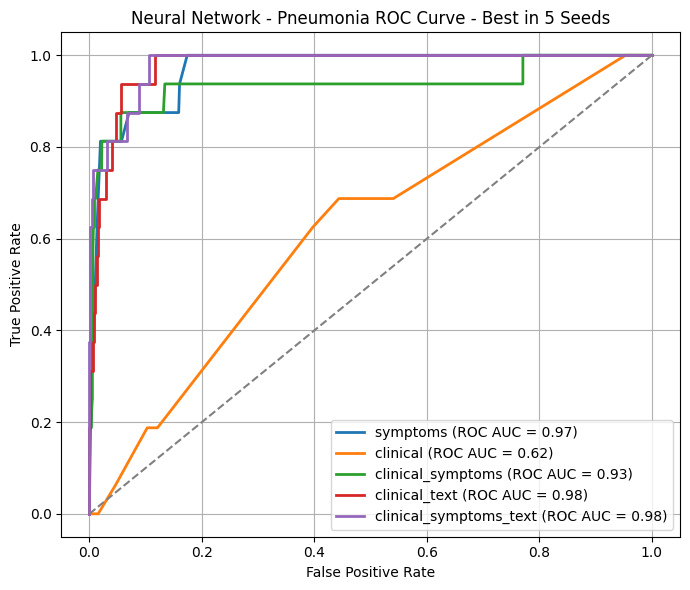

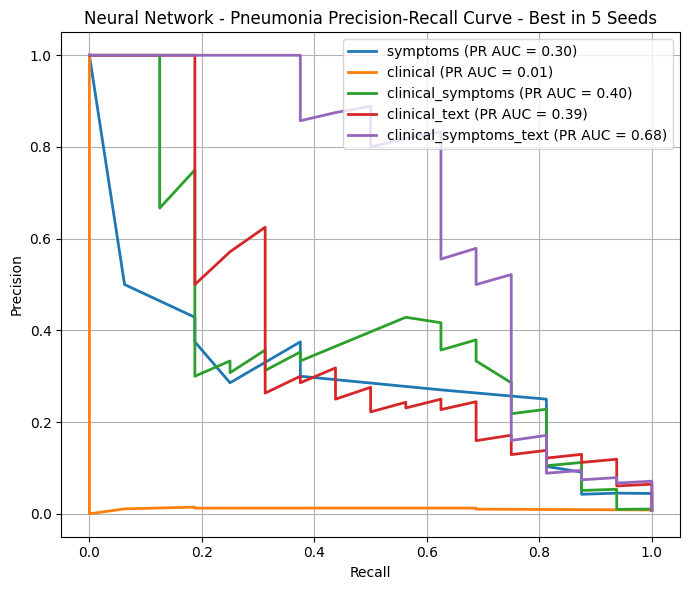

In [6]:
# In kết quả tốt nhất của mỗi input_type
print("\n🎯 Best results by input_type (based on PR AUC):")
for input_type, result in all_results.items():
    print(f"  - {input_type:15}: Seed = {result['seed']}, ROC AUC = {result['roc_auc']:.4f}, PR AUC = {result['pr_auc']:.4f}")

# === ROC CURVE CHO NHIỀU INPUT_TYPE ===
plt.figure(figsize=(7, 6))
for input_type, result in all_results.items():
    plt.plot(result['fpr'], result['tpr'], lw=2,
             label=f"{input_type} (ROC AUC = {result['roc_auc']:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Neural Network - Pneumonia ROC Curve - Best in 5 Seeds")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# === PRECISION-RECALL CURVE CHO NHIỀU INPUT_TYPE ===
plt.figure(figsize=(7, 6))
for input_type, result in all_results.items():
    plt.plot(result['recall'], result['precision'], lw=2,
             label=f"{input_type} (PR AUC = {result['pr_auc']:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Neural Network - Pneumonia Precision-Recall Curve - Best in 5 Seeds")
plt.legend(loc="upper right")
plt.grid(True)
plt.xticks(np.linspace(0, 1, 6))
plt.yticks(np.linspace(0, 1, 6))
plt.tight_layout()
plt.show()



In [7]:
input_types = ['symptoms', 'clinical', 'clinical_symptoms', 'clinical_text', 'clinical_symptoms_text']
all_results = {}

for input_type in input_types:
    print(f"\n Running input_type: {input_type}")
    best_pr_auc = -1
    best_result = None

    for seed in [21, 2, 13, 3, 2023]:
        print(f"  ➤ Seed {seed}")
        np.random.seed(seed)
        tf.random.set_seed(seed)

        model, roc_auc, fpr, tpr, recall, precision = NN_model_train(
            target='inf',
            df_train=train_df,
            df_test=test_df,
            input_type=input_type,
            emb='hist_emb'
        )

        pr_auc = auc(recall, precision)

        if pr_auc > best_pr_auc:
            best_pr_auc = pr_auc
            best_result = {
                'seed': seed,
                'roc_auc': roc_auc,
                'pr_auc': pr_auc,
                'fpr': fpr,
                'tpr': tpr,
                'recall': recall,
                'precision': precision
            }

    all_results[input_type] = best_result




 Running input_type: symptoms
  ➤ Seed 21
y_train shape: (8000,)
Input features: 5


C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_75 (Dense)                │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7172 - loss: 0.5671 - val_accuracy: 0.8094 - val_loss: 0.3975
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8168 - loss: 0.3911 - val_accuracy: 0.8075 - val_loss: 0.3717
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8111 - loss: 0.3864 - val_accuracy: 0.8075 - val_loss: 0.3765
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8131 - loss: 0.3846 - val_accuracy: 0.8075 - val_loss: 0.3787
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8130 - loss: 0.3837 - val_accuracy: 0.8075 - val_loss: 0.3809
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8130 - loss: 0.3833 - val_accuracy: 0.8075 - val_loss: 0.3825
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8130 - loss: 0.3830 - val_accuracy: 0.8037 - val_loss: 0.3836
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_78 (Dense)                │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6820 - loss: 0.5748 - val_accuracy: 0.8081 - val_loss: 0.4336
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8091 - loss: 0.3781 - val_accuracy: 0.7981 - val_loss: 0.3924
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8046 - loss: 0.3744 - val_accuracy: 0.7981 - val_loss: 0.3932
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8070 - loss: 0.3741 - val_accuracy: 0.7981 - val_loss: 0.3964
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8072 - loss: 0.3739 - val_accuracy: 0.7981 - val_loss: 0.3983
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8069 - loss: 0.3737 - val_accuracy: 0.7981 - val_loss: 0.4008
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8070 - loss: 0.3738 - val_accuracy: 0.7981 - val_loss: 0.4013
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_81 (Dense)                │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6352 - loss: 0.5599 - val_accuracy: 0.8050 - val_loss: 0.4378
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8117 - loss: 0.3727 - val_accuracy: 0.7981 - val_loss: 0.4038
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8077 - loss: 0.3662 - val_accuracy: 0.7981 - val_loss: 0.3996
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8075 - loss: 0.3654 - val_accuracy: 0.7981 - val_loss: 0.3976
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8084 - loss: 0.3650 - val_accuracy: 0.7981 - val_loss: 0.3958
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8084 - loss: 0.3648 - val_accuracy: 0.7981 - val_loss: 0.3941
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8088 - loss: 0.3646 - val_accuracy: 0.8012 - val_loss: 0.3927
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_84 (Dense)                │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6916 - loss: 0.5894 - val_accuracy: 0.8144 - val_loss: 0.3835
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8192 - loss: 0.3748 - val_accuracy: 0.8075 - val_loss: 0.3533
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8140 - loss: 0.3669 - val_accuracy: 0.8106 - val_loss: 0.3494
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8156 - loss: 0.3653 - val_accuracy: 0.8131 - val_loss: 0.3483
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8167 - loss: 0.3644 - val_accuracy: 0.8131 - val_loss: 0.3471
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8174 - loss: 0.3639 - val_accuracy: 0.8131 - val_loss: 0.3465
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8179 - loss: 0.3635 - val_accuracy: 0.8131 - val_loss: 0.3457
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_87 (Dense)                │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6643 - loss: 0.5749 - val_accuracy: 0.8163 - val_loss: 0.3745
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8128 - loss: 0.3842 - val_accuracy: 0.8144 - val_loss: 0.3401
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8132 - loss: 0.3771 - val_accuracy: 0.8131 - val_loss: 0.3388
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8127 - loss: 0.3759 - val_accuracy: 0.8131 - val_loss: 0.3390
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8113 - loss: 0.3753 - val_accuracy: 0.8131 - val_loss: 0.3404
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8116 - loss: 0.3749 - val_accuracy: 0.8131 - val_loss: 0.3413
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8120 - loss: 0.3747 - val_accuracy: 0.8131 - val_loss: 0.3429
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_90 (Dense)                │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7255 - loss: 0.5968 - val_accuracy: 0.7669 - val_loss: 0.4862
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7823 - loss: 0.4784 - val_accuracy: 0.7669 - val_loss: 0.4808
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7818 - loss: 0.4758 - val_accuracy: 0.7669 - val_loss: 0.4841
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7818 - loss: 0.4753 - val_accuracy: 0.7669 - val_loss: 0.4863
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7818 - loss: 0.4750 - val_accuracy: 0.7669 - val_loss: 0.4878
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7818 - loss: 0.4746 - val_accuracy: 0.7669 - val_loss: 0.4886
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7818 - loss: 0.4744 - val_accuracy: 0.7669 - val_loss: 0.4894
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_93 (Dense)                │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7185 - loss: 0.6186 - val_accuracy: 0.7669 - val_loss: 0.5319
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7764 - loss: 0.4891 - val_accuracy: 0.7669 - val_loss: 0.5165
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7764 - loss: 0.4860 - val_accuracy: 0.7669 - val_loss: 0.5183
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7764 - loss: 0.4853 - val_accuracy: 0.7669 - val_loss: 0.5193
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7764 - loss: 0.4851 - val_accuracy: 0.7669 - val_loss: 0.5188
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7764 - loss: 0.4849 - val_accuracy: 0.7669 - val_loss: 0.5184
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7764 - loss: 0.4847 - val_accuracy: 0.7669 - val_loss: 0.5190
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_96 (Dense)                │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7308 - loss: 0.6156 - val_accuracy: 0.7669 - val_loss: 0.5441
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7649 - loss: 0.4956 - val_accuracy: 0.7669 - val_loss: 0.5233
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7649 - loss: 0.4936 - val_accuracy: 0.7669 - val_loss: 0.5189
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7649 - loss: 0.4932 - val_accuracy: 0.7669 - val_loss: 0.5166
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7649 - loss: 0.4929 - val_accuracy: 0.7669 - val_loss: 0.5145
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7649 - loss: 0.4927 - val_accuracy: 0.7669 - val_loss: 0.5137
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7649 - loss: 0.4926 - val_accuracy: 0.7669 - val_loss: 0.5127
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_99 (Dense)                │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7028 - loss: 0.5995 - val_accuracy: 0.7669 - val_loss: 0.4918
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7725 - loss: 0.4930 - val_accuracy: 0.7669 - val_loss: 0.4828
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7725 - loss: 0.4902 - val_accuracy: 0.7669 - val_loss: 0.4854
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7725 - loss: 0.4894 - val_accuracy: 0.7669 - val_loss: 0.4862
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7725 - loss: 0.4890 - val_accuracy: 0.7669 - val_loss: 0.4868
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7725 - loss: 0.4887 - val_accuracy: 0.7669 - val_loss: 0.4869
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7725 - loss: 0.4884 - val_accuracy: 0.7669 - val_loss: 0.4877
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_102 (Dense)               │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6691 - loss: 0.6074 - val_accuracy: 0.7669 - val_loss: 0.5047
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7753 - loss: 0.4928 - val_accuracy: 0.7669 - val_loss: 0.4902
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7753 - loss: 0.4908 - val_accuracy: 0.7669 - val_loss: 0.4888
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7753 - loss: 0.4904 - val_accuracy: 0.7669 - val_loss: 0.4885
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7753 - loss: 0.4902 - val_accuracy: 0.7669 - val_loss: 0.4880
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7753 - loss: 0.4901 - val_accuracy: 0.7669 - val_loss: 0.4878
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7753 - loss: 0.4900 - val_accuracy: 0.7669 - val_loss: 0.4878
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_105 (Dense)               │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,585 (76.50 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6493 - loss: 0.5426 - val_accuracy: 0.9081 - val_loss: 0.2800
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9033 - loss: 0.2872 - val_accuracy: 0.9069 - val_loss: 0.2593
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9036 - loss: 0.2771 - val_accuracy: 0.9062 - val_loss: 0.2594
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9037 - loss: 0.2730 - val_accuracy: 0.9081 - val_loss: 0.2577
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9053 - loss: 0.2709 - val_accuracy: 0.9075 - val_loss: 0.2570
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9054 - loss: 0.2693 - val_accuracy: 0.9075 - val_loss: 0.2567
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9064 - loss: 0.2681 - val_accuracy: 0.9081 - val_loss: 0.2566
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_108 (Dense)               │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,585 (76.50 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6794 - loss: 0.5352 - val_accuracy: 0.8925 - val_loss: 0.2901
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9040 - loss: 0.2794 - val_accuracy: 0.8969 - val_loss: 0.2681
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9058 - loss: 0.2701 - val_accuracy: 0.8938 - val_loss: 0.2670
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9062 - loss: 0.2675 - val_accuracy: 0.8944 - val_loss: 0.2665
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9072 - loss: 0.2657 - val_accuracy: 0.8925 - val_loss: 0.2675
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9076 - loss: 0.2645 - val_accuracy: 0.8913 - val_loss: 0.2683
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9073 - loss: 0.2637 - val_accuracy: 0.8919 - val_loss: 0.2695
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_111 (Dense)               │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,585 (76.50 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7573 - loss: 0.5548 - val_accuracy: 0.8637 - val_loss: 0.3457
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9010 - loss: 0.2757 - val_accuracy: 0.8869 - val_loss: 0.3246
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9036 - loss: 0.2707 - val_accuracy: 0.8850 - val_loss: 0.3192
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9021 - loss: 0.2688 - val_accuracy: 0.8838 - val_loss: 0.3163
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9008 - loss: 0.2677 - val_accuracy: 0.8831 - val_loss: 0.3141
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8994 - loss: 0.2669 - val_accuracy: 0.8825 - val_loss: 0.3117
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8998 - loss: 0.2661 - val_accuracy: 0.8831 - val_loss: 0.3101
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_114 (Dense)               │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,585 (76.50 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6547 - loss: 0.5531 - val_accuracy: 0.8938 - val_loss: 0.2773
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9066 - loss: 0.2790 - val_accuracy: 0.9050 - val_loss: 0.2499
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9075 - loss: 0.2669 - val_accuracy: 0.9062 - val_loss: 0.2455
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9088 - loss: 0.2629 - val_accuracy: 0.9081 - val_loss: 0.2433
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9094 - loss: 0.2603 - val_accuracy: 0.9094 - val_loss: 0.2421
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9085 - loss: 0.2586 - val_accuracy: 0.9094 - val_loss: 0.2411
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9106 - loss: 0.2572 - val_accuracy: 0.9106 - val_loss: 0.2410
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_117 (Dense)               │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,585 (76.50 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6887 - loss: 0.5379 - val_accuracy: 0.8944 - val_loss: 0.2746
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9054 - loss: 0.2851 - val_accuracy: 0.8956 - val_loss: 0.2534
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9061 - loss: 0.2777 - val_accuracy: 0.8963 - val_loss: 0.2492
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9066 - loss: 0.2748 - val_accuracy: 0.8969 - val_loss: 0.2472
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9064 - loss: 0.2732 - val_accuracy: 0.8969 - val_loss: 0.2462
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9070 - loss: 0.2720 - val_accuracy: 0.8988 - val_loss: 0.2457
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9059 - loss: 0.2711 - val_accuracy: 0.8994 - val_loss: 0.2454
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_120 (Dense)               │ (None, 256)            │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 214,657 (838.50 KB)

 Trainable params: 214,657 (838.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8153 - loss: 0.5088 - val_accuracy: 0.8788 - val_loss: 0.3097
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8586 - loss: 0.3384 - val_accuracy: 0.8844 - val_loss: 0.2911
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8679 - loss: 0.3184 - val_accuracy: 0.8888 - val_loss: 0.2806
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8763 - loss: 0.3033 - val_accuracy: 0.8906 - val_loss: 0.2730
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8806 - loss: 0.2918 - val_accuracy: 0.8944 - val_loss: 0.2666
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8851 - loss: 0.2825 - val_accuracy: 0.8963 - val_loss: 0.2618
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8899 - loss: 0.2746 - val_accuracy: 0.8969 - val_loss: 0.2580
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_123 (Dense)               │ (None, 256)            │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 214,657 (838.50 KB)

 Trainable params: 214,657 (838.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8077 - loss: 0.5225 - val_accuracy: 0.8737 - val_loss: 0.3130
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8590 - loss: 0.3395 - val_accuracy: 0.8744 - val_loss: 0.3102
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8717 - loss: 0.3211 - val_accuracy: 0.8800 - val_loss: 0.3008
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8778 - loss: 0.3061 - val_accuracy: 0.8881 - val_loss: 0.2877
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8849 - loss: 0.2935 - val_accuracy: 0.8906 - val_loss: 0.2803
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8897 - loss: 0.2829 - val_accuracy: 0.8931 - val_loss: 0.2748
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8936 - loss: 0.2738 - val_accuracy: 0.8931 - val_loss: 0.2719
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_126 (Dense)               │ (None, 256)            │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_127 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 214,657 (838.50 KB)

 Trainable params: 214,657 (838.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6934 - loss: 0.5283 - val_accuracy: 0.8225 - val_loss: 0.4085
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8558 - loss: 0.3421 - val_accuracy: 0.8250 - val_loss: 0.4028
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8645 - loss: 0.3247 - val_accuracy: 0.8275 - val_loss: 0.3965
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8709 - loss: 0.3107 - val_accuracy: 0.8381 - val_loss: 0.3860
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8798 - loss: 0.2986 - val_accuracy: 0.8419 - val_loss: 0.3778
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8816 - loss: 0.2891 - val_accuracy: 0.8400 - val_loss: 0.3735
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8876 - loss: 0.2807 - val_accuracy: 0.8469 - val_loss: 0.3685
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_129 (Dense)               │ (None, 256)            │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_130 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_131 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 214,657 (838.50 KB)

 Trainable params: 214,657 (838.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7927 - loss: 0.5036 - val_accuracy: 0.8844 - val_loss: 0.2953
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8610 - loss: 0.3334 - val_accuracy: 0.8869 - val_loss: 0.2895
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8713 - loss: 0.3120 - val_accuracy: 0.8913 - val_loss: 0.2732
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8844 - loss: 0.2984 - val_accuracy: 0.9000 - val_loss: 0.2647
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8895 - loss: 0.2870 - val_accuracy: 0.8994 - val_loss: 0.2599
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8977 - loss: 0.2773 - val_accuracy: 0.9019 - val_loss: 0.2574
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9011 - loss: 0.2689 - val_accuracy: 0.9019 - val_loss: 0.2568
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_132 (Dense)               │ (None, 256)            │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 214,657 (838.50 KB)

 Trainable params: 214,657 (838.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7948 - loss: 0.5118 - val_accuracy: 0.8581 - val_loss: 0.3345
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8536 - loss: 0.3451 - val_accuracy: 0.8881 - val_loss: 0.2900
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8666 - loss: 0.3288 - val_accuracy: 0.8881 - val_loss: 0.2852
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8752 - loss: 0.3152 - val_accuracy: 0.8950 - val_loss: 0.2767
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8800 - loss: 0.3052 - val_accuracy: 0.8956 - val_loss: 0.2700
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8843 - loss: 0.2966 - val_accuracy: 0.8988 - val_loss: 0.2657
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8867 - loss: 0.2893 - val_accuracy: 0.8975 - val_loss: 0.2630
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_135 (Dense)               │ (None, 256)            │       199,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,193 (844.50 KB)

 Trainable params: 216,193 (844.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7602 - loss: 0.4741 - val_accuracy: 0.9062 - val_loss: 0.2359
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8944 - loss: 0.2887 - val_accuracy: 0.9062 - val_loss: 0.2380
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9023 - loss: 0.2744 - val_accuracy: 0.9106 - val_loss: 0.2319
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9055 - loss: 0.2674 - val_accuracy: 0.9125 - val_loss: 0.2279
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9072 - loss: 0.2611 - val_accuracy: 0.9137 - val_loss: 0.2244
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9083 - loss: 0.2546 - val_accuracy: 0.9125 - val_loss: 0.2217
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9112 - loss: 0.2478 - val_accuracy: 0.9131 - val_loss: 0.2202
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_138 (Dense)               │ (None, 256)            │       199,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_140 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,193 (844.50 KB)

 Trainable params: 216,193 (844.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8003 - loss: 0.4805 - val_accuracy: 0.9013 - val_loss: 0.2532
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9046 - loss: 0.2794 - val_accuracy: 0.9038 - val_loss: 0.2475
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9075 - loss: 0.2685 - val_accuracy: 0.9038 - val_loss: 0.2495
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9095 - loss: 0.2608 - val_accuracy: 0.9031 - val_loss: 0.2494
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9124 - loss: 0.2544 - val_accuracy: 0.9038 - val_loss: 0.2483
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9133 - loss: 0.2484 - val_accuracy: 0.9062 - val_loss: 0.2468
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9154 - loss: 0.2424 - val_accuracy: 0.9056 - val_loss: 0.2450
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_141 (Dense)               │ (None, 256)            │       199,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,193 (844.50 KB)

 Trainable params: 216,193 (844.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7998 - loss: 0.4897 - val_accuracy: 0.8550 - val_loss: 0.3617
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8991 - loss: 0.2802 - val_accuracy: 0.8556 - val_loss: 0.3587
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9004 - loss: 0.2692 - val_accuracy: 0.8575 - val_loss: 0.3524
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9048 - loss: 0.2621 - val_accuracy: 0.8606 - val_loss: 0.3497
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9050 - loss: 0.2560 - val_accuracy: 0.8637 - val_loss: 0.3471
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9085 - loss: 0.2500 - val_accuracy: 0.8669 - val_loss: 0.3426
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9103 - loss: 0.2436 - val_accuracy: 0.8662 - val_loss: 0.3431
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_144 (Dense)               │ (None, 256)            │       199,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,193 (844.50 KB)

 Trainable params: 216,193 (844.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8229 - loss: 0.5001 - val_accuracy: 0.9119 - val_loss: 0.2330
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9039 - loss: 0.2793 - val_accuracy: 0.9094 - val_loss: 0.2397
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9100 - loss: 0.2623 - val_accuracy: 0.9081 - val_loss: 0.2406
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9122 - loss: 0.2550 - val_accuracy: 0.9100 - val_loss: 0.2392
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9146 - loss: 0.2490 - val_accuracy: 0.9100 - val_loss: 0.2379
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9175 - loss: 0.2435 - val_accuracy: 0.9106 - val_loss: 0.2363
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9195 - loss: 0.2379 - val_accuracy: 0.9106 - val_loss: 0.2367
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_147 (Dense)               │ (None, 256)            │       199,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_148 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,193 (844.50 KB)

 Trainable params: 216,193 (844.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6993 - loss: 0.4923 - val_accuracy: 0.8956 - val_loss: 0.2878
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8958 - loss: 0.2863 - val_accuracy: 0.9056 - val_loss: 0.2376
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9077 - loss: 0.2727 - val_accuracy: 0.9100 - val_loss: 0.2380
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9096 - loss: 0.2654 - val_accuracy: 0.9131 - val_loss: 0.2350
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9149 - loss: 0.2602 - val_accuracy: 0.9162 - val_loss: 0.2323
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9158 - loss: 0.2549 - val_accuracy: 0.9150 - val_loss: 0.2305
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9169 - loss: 0.2499 - val_accuracy: 0.9169 - val_loss: 0.2288
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accu


🎯 Best results by input_type (based on PR AUC):
  - symptoms       : Seed = 21, ROC AUC = 0.9043, PR AUC = 0.7731
  - clinical       : Seed = 3, ROC AUC = 0.8186, PR AUC = 0.4576
  - clinical_symptoms: Seed = 13, ROC AUC = 0.9576, PR AUC = 0.8918
  - clinical_text  : Seed = 2, ROC AUC = 0.9523, PR AUC = 0.8790
  - clinical_symptoms_text: Seed = 2, ROC AUC = 0.9621, PR AUC = 0.9082


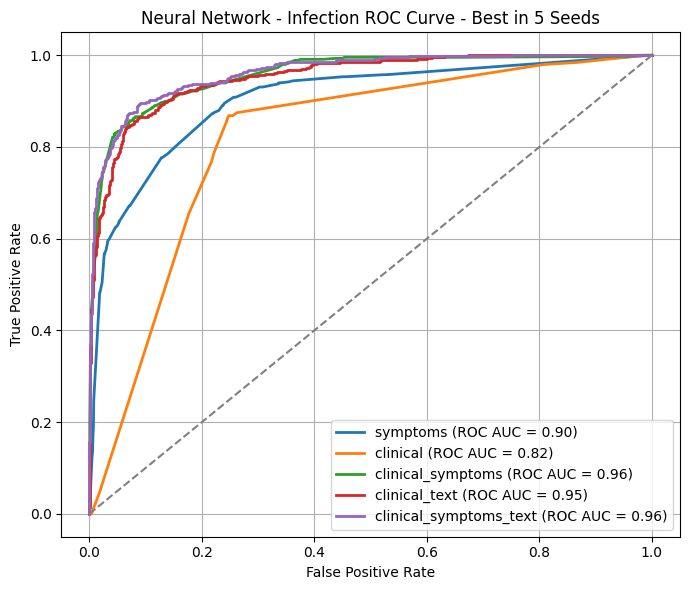

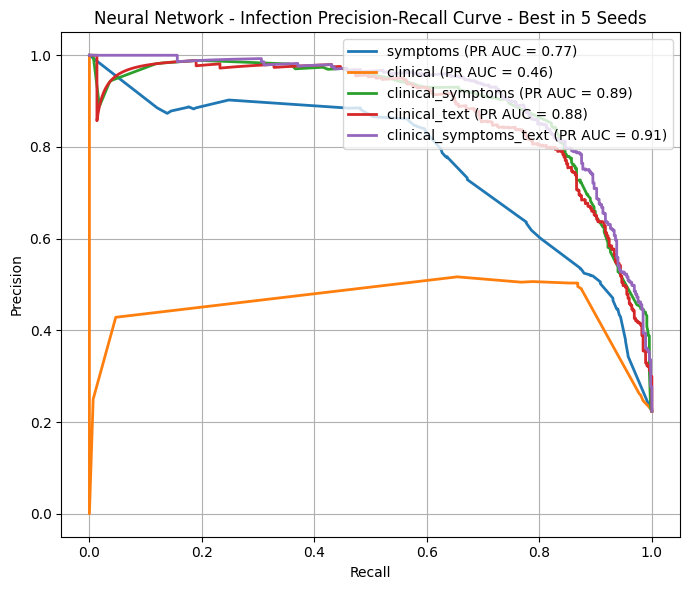

In [8]:
# In kết quả tốt nhất của mỗi input_type
print("\n🎯 Best results by input_type (based on PR AUC):")
for input_type, result in all_results.items():
    print(f"  - {input_type:15}: Seed = {result['seed']}, ROC AUC = {result['roc_auc']:.4f}, PR AUC = {result['pr_auc']:.4f}")

# === ROC CURVE CHO NHIỀU INPUT_TYPE ===
plt.figure(figsize=(7, 6))
for input_type, result in all_results.items():
    plt.plot(result['fpr'], result['tpr'], lw=2,
             label=f"{input_type} (ROC AUC = {result['roc_auc']:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Neural Network - Infection ROC Curve - Best in 5 Seeds")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# === PRECISION-RECALL CURVE CHO NHIỀU INPUT_TYPE ===
plt.figure(figsize=(7, 6))
for input_type, result in all_results.items():
    plt.plot(result['recall'], result['precision'], lw=2,
             label=f"{input_type} (PR AUC = {result['pr_auc']:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Neural Network - Infection Precision-Recall Curve - Best in 5 Seeds")
plt.legend(loc="upper right")
plt.grid(True)
plt.xticks(np.linspace(0, 1, 6))
plt.yticks(np.linspace(0, 1, 6))
plt.tight_layout()
plt.show()

